1.install and import Packages

In [1]:
#!pip3 install tensorflow-gpu==2.4.1
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [2]:
     !pip install opencv-python 

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp


2. Keypoints using MP Holistic


In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

3. Extract Keypoint Values


In [9]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [10]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

4. Setup Folders for Collection


In [11]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Final') 

# Actions that we try to detect
actions = np.array(['Salut', 'Merci', 'Docteur','Malade','au revoir',"j'ai mal a la tete",'medicament','vomissements','cancer','operation'])

# Thirty videos worth of data
no_sequences = 10

# Videos are going to be 30 frames in length
sequence_length = 10

In [12]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

5. Collect Keypoint Values for Training and Testing


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

6. Preprocess Data and Create Labels and Features


In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
label_map = {label:num for num, label in enumerate(actions)}

In [15]:
label_map

{'Salut': 0,
 'Merci': 1,
 'Docteur': 2,
 'Malade': 3,
 'au revoir': 4,
 "j'ai mal a la tete": 5,
 'medicament': 6,
 'vomissements': 7,
 'cancer': 8,
 'operation': 9}

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
np.array(sequences).shape


(100, 10, 1662)

In [18]:
np.array(labels).shape

(100,)

In [19]:
X = np.array(sequences)

In [20]:
X.shape

(100, 10, 1662)

In [21]:
y = to_categorical(labels).astype(int)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [23]:
y_test.shape

(5, 10)

7. Build and Train LSTM Neural Network

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [25]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [26]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [27]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [28]:
model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
3/3 [==============================] - 5s 43ms/step - loss: 2.3710 - categorical_accuracy: 0.0737
Epoch 2/100
3/3 [==============================] - 0s 27ms/step - loss: 2.2954 - categorical_accuracy: 0.0947
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 2.2981 - categorical_accuracy: 0.0947
Epoch 4/100
3/3 [==============================] - 0s 31ms/step - loss: 2.2825 - categorical_accuracy: 0.0947
Epoch 5/100
3/3 [==============================] - 0s 26ms/step - loss: 2.2405 - categorical_accuracy: 0.1053
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 2.1839 - categorical_accuracy: 0.1895
Epoch 7/100
3/3 [==============================] - 0s 25ms/step - loss: 2.1161 - categorical_accuracy: 0.1895
Epoch 8/100
3/3 [==============================] - 0s 26ms/step - loss: 2.0425 - categorical_accuracy: 0.2316
Epoch 9/100
3/3 [==============================] - 0s 23ms/step - loss: 1.9227 - categorical_accuracy: 0.2421
Epoch 10/1

3/3 [==============================] - 0s 31ms/step - loss: 0.2662 - categorical_accuracy: 0.8842
Epoch 75/100
3/3 [==============================] - 0s 29ms/step - loss: 0.2772 - categorical_accuracy: 0.9263
Epoch 76/100
3/3 [==============================] - 0s 30ms/step - loss: 0.2002 - categorical_accuracy: 0.9579
Epoch 77/100
3/3 [==============================] - 0s 32ms/step - loss: 0.1472 - categorical_accuracy: 0.9895
Epoch 78/100
3/3 [==============================] - 0s 25ms/step - loss: 0.1486 - categorical_accuracy: 0.9579
Epoch 79/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0816 - categorical_accuracy: 0.9895
Epoch 80/100
3/3 [==============================] - 0s 32ms/step - loss: 0.0599 - categorical_accuracy: 1.0000
Epoch 81/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0625 - categorical_accuracy: 0.9895
Epoch 82/100
3/3 [==============================] - 0s 33ms/step - loss: 0.0339 - categorical_accuracy: 1.0000
Epoch 83/100
3

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 596,906
Trainable params: 596,906
Non-trai

8. Make Predictions

In [30]:
res = model.predict(X_test)

1/1 [==============================] - 0s 452ms/step


In [31]:
actions[np.argmax(res[4])]

'operation'

In [32]:
actions[np.argmax(y_test[4])]

'medicament'

9. Save Weights

In [33]:
model.save('action.h5')

In [34]:
model.load_weights('action.h5')


10. Evaluation using Confusion Matrix and Accuracy


In [35]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [36]:
yhat = model.predict(X_test)


1/1 [==============================] - 0s 27ms/step


In [37]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [38]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[4, 0],
        [0, 1]],

       [[4, 0],
        [0, 1]],

       [[3, 0],
        [1, 1]],

       [[4, 1],
        [0, 0]]], dtype=int64)

In [39]:
accuracy_score(ytrue, yhat)

0.8

11. Test in Real Time

In [40]:
from scipy import stats


In [41]:
colors = [(245,117,16), (117,245,16), (116,107,25), (126,17,145), (179,12,45), (85,55,145), (55,144,44), (5,45,55), (190,96,30), (115,48,235)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [42]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-10:]
        
        if len(sequence) == 10:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (255, 255, 255), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Salut
<class 'mediapipe.python.so

1/1 [==============================] - 0s 28ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [===================

1/1 [==============================] - 0s 16ms/step
Malade
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Malade
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
au revoir
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
au revoir
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 6ms/step
au revoir
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
au revoir
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
au revoir
<

1/1 [==============================] - 0s 24ms/step
au revoir
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Docteur
<class

1/1 [==============================] - 0s 25ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Merci
<class 'mediapipe.pyth

1/1 [==============================] - 0s 19ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Docteur
<cla

1/1 [==============================] - 0s 22ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
operation
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
operation
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
operation
<class

1/1 [==============================] - 0s 27ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 14ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Docteur
<cla

1/1 [==============================] - 0s 30ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0

1/1 [==============================] - 0s 20ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
cancer
<class 'media

1/1 [==============================] - 0s 18ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
cancer
<class 'm

1/1 [==============================] - 0s 24ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Docteur
<cla

1/1 [==============================] - 0s 14ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
Salut
<class 'mediapipe.pyth

In [42]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-10:]
        
        if len(sequence) == 10:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (255, 255, 255), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Salut
<class 'mediapipe.python.so

1/1 [==============================] - 0s 28ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
vomissements
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [===================

1/1 [==============================] - 0s 16ms/step
Malade
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Malade
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
au revoir
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
au revoir
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 6ms/step
au revoir
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
au revoir
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
au revoir
<

1/1 [==============================] - 0s 25ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Merci
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Merci
<class 'mediapipe.pyth

1/1 [==============================] - 0s 19ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Docteur
<cla

1/1 [==============================] - 0s 22ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Salut
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
operation
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
operation
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
operation
<class

1/1 [==============================] - 0s 30ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
medicament
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0

1/1 [==============================] - 0s 20ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
cancer
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
cancer
<class 'media

1/1 [==============================] - 0s 24ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
Docteur
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Docteur
<cla

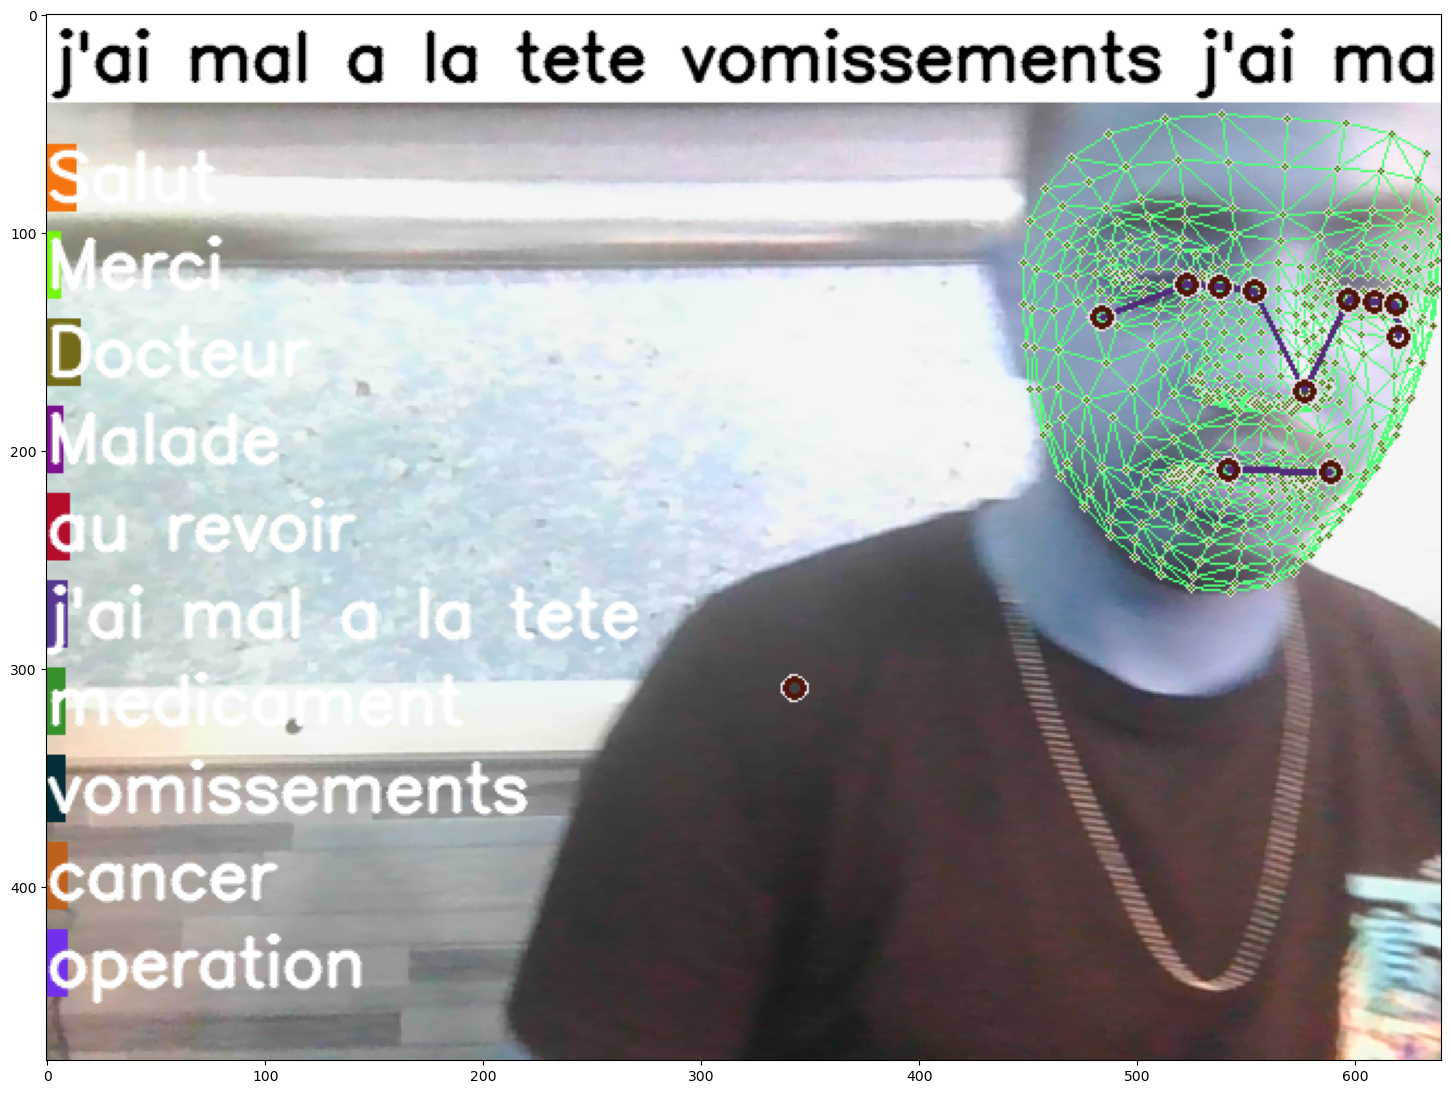

In [50]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))